In [1]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt

In [69]:
conn = psycopg2.connect(
    host="srdcvadmcapd01",
    user="postgres",
    password="Admin@123",
    database="AI_CodeReview"
)
query = "SELECT * FROM api_usage_data"

# Query data
cur = conn.cursor()
cur.execute(query)

# Fetch all rows and create a DataFrame
result = cur.fetchall()
df = pd.DataFrame(result, columns=["id", "repository", "pr_url", "num_github_api_calls", "num_llm_api_calls", "num_llm_total_tokens", "avg_llm_call_in_s", "program_start_timestamp"])
df = df.drop('id', axis=1)
# Close database connection
cur.close()
conn.close()
df.shape

(923, 7)

In [70]:
# Convert program_start_timestamp column to pandas datetime type
df['program_start_timestamp'] = pd.to_datetime(df['program_start_timestamp'])
df['program_start_timestamp'] = df['program_start_timestamp'].dt.tz_localize('UTC')
df['program_start_timestamp'] = df['program_start_timestamp'].dt.tz_convert('EST')
df['hour'] = df['program_start_timestamp'].dt.hour
df['date'] = df['program_start_timestamp'].dt.date

In [71]:
df.describe()

num_github_api_calls  num_llm_api_calls  num_llm_total_tokens  \
count            923.000000         923.000000            923.000000   
mean               6.177681          12.696641           9867.435536   
std                1.887526           9.883105           9888.713380   
min                2.000000           1.000000            254.000000   
25%                5.000000           5.000000           3110.500000   
50%                6.000000           8.000000           6660.000000   
75%                8.000000          18.000000          13983.500000   
max               21.000000          71.000000          95467.000000   

             hour  
count  923.000000  
mean    13.200433  
std      4.872108  
min      0.000000  
25%     11.000000  
50%     14.000000  
75%     16.000000  
max     23.000000

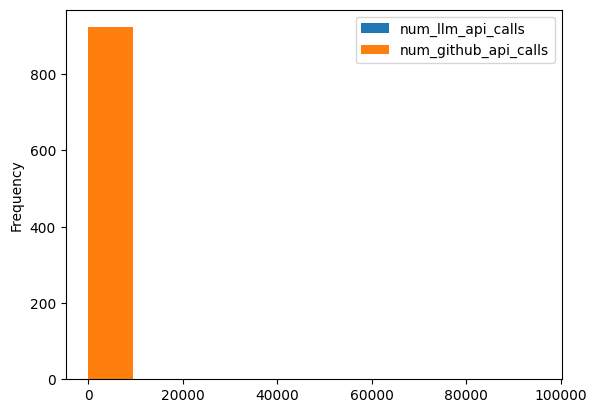

In [72]:
df.plot.hist(column=["num_llm_api_calls", "num_github_api_calls"])
# plt.xticks(df['program_start_timestamp'].dt.date, fontsize=10, rotation=90)
plt.legend()
plt.show()

In [39]:
df[['pr_url', 'num_github_api_calls', 'num_llm_api_calls', 'avg_llm_call_in_s', 'program_start_timestamp']].head()

pr_url  num_github_api_calls  \
0  https://github.amd.com/ATG/SysArch-AICodeRevie...                     4   
1  https://github.amd.com/ATG/SysArch-AICodeRevie...                     6   
2  https://github.amd.com/AMD-Radeon-Driver/dal/p...                     5   
3  https://github.amd.com/AMD-Radeon-Driver/dal/p...                     5   
4  https://github.amd.com/AMD-Radeon-Driver/dal/p...                     5   

   num_llm_api_calls avg_llm_call_in_s   program_start_timestamp  
0                  4              9.10 2024-02-01 16:59:34-05:00  
1                 12             20.92 2024-02-01 17:03:37-05:00  
2                  1              6.94 2024-02-05 11:15:40-05:00  
3                  1              4.87 2024-02-05 11:16:47-05:00  
4                  5             13.99 2024-02-05 11:31:32-05:00

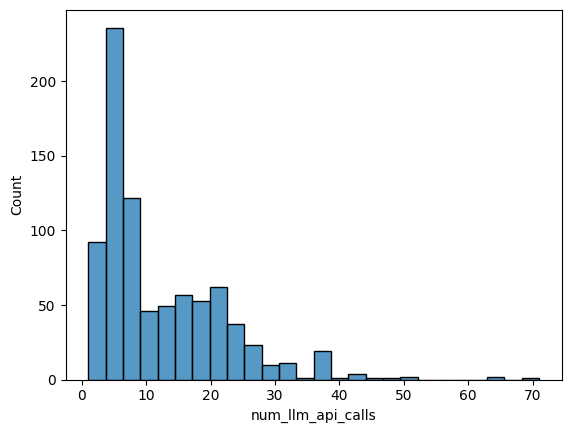

In [52]:
import seaborn as sns

sns.histplot(data=df, x='num_llm_api_calls')
plt.show()

In [58]:
df.groupby(pd.Grouper(key='program_start_timestamp', freq='10min')).agg({'num_llm_api_calls': 'mean', 'num_github_api_calls': 'mean', 'num_llm_total_tokens': 'mean'})

num_llm_api_calls  num_github_api_calls  \
program_start_timestamp                                              
2024-02-01 16:50:00-05:00                4.0                   4.0   
2024-02-01 17:00:00-05:00               12.0                   6.0   
2024-02-01 17:10:00-05:00                NaN                   NaN   
2024-02-01 17:20:00-05:00                NaN                   NaN   
2024-02-01 17:30:00-05:00                NaN                   NaN   
...                                      ...                   ...   
2024-02-16 15:40:00-05:00                NaN                   NaN   
2024-02-16 15:50:00-05:00               11.0                   7.0   
2024-02-16 16:00:00-05:00                9.5                   5.5   
2024-02-16 16:10:00-05:00               20.0                   8.0   
2024-02-16 16:20:00-05:00                8.0                   8.0   

                           num_llm_total_tokens  
program_start_timestamp                          
2024-02-01 16:50:00-05:00                1490.0  
2024-02-01 17:00:00-05:00               12955.0  
2024-02-01 17:10:00-05:00                   NaN  
2024-02-01 17:20:00-05:00                   NaN  
2024-02-01 17:30:00-05:00                   NaN  
...                                         ...  
2024-02-16 15:40:00-05:00                   NaN  
2024-02-16 15:50:00-05:00                4386.0  
2024-02-16 16:00:00-05:00                2965.5  
2024-02-16 16:10:00-05:00               11649.0  
2024-02-16 16:20:00-05:00                5554.0  

[2158 rows x 3 columns]

In [80]:
# Aggregate data by time_bucket
avg_hourly_df = df.groupby('hour').agg({'num_llm_api_calls': 'mean', 'num_github_api_calls': 'mean', 'num_llm_total_tokens': 'mean'})
max_date_df = df.groupby('date').agg({'num_llm_api_calls': 'max', 'num_github_api_calls': 'max', 'num_llm_total_tokens': 'max'})

start, end = df['program_start_timestamp'].min().date(), df['program_start_timestamp'].max().date()

max_date_df

num_llm_api_calls  num_github_api_calls  num_llm_total_tokens
date                                                                     
2024-02-01                 12                     6                 12955
2024-02-05                 36                     8                 25094
2024-02-06                 36                     9                 95467
2024-02-07                 36                    18                 42423
2024-02-08                 38                     8                 35620
2024-02-09                 50                    21                 37209
2024-02-10                  3                     3                   962
2024-02-11                  3                     3                   774
2024-02-12                 33                     9                 49729
2024-02-13                 71                     8                 57483
2024-02-14                 38                     8                 61872
2024-02-15                 43                     9                 49716
2024-02-16                 45                    21                 46703
2024-02-17                 13                     4                  9966
2024-02-18                 36                     8                 42653
2024-02-19                 36                    14                 41239
2024-02-20                 42                     9                 31432

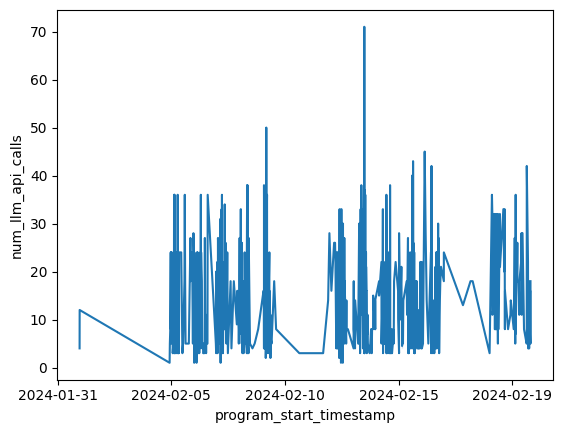

In [83]:
sns.lineplot(data=df, x='program_start_timestamp', y='num_llm_api_calls')
plt.xticks(pd.date_range(start, end, periods=5))
plt.show()

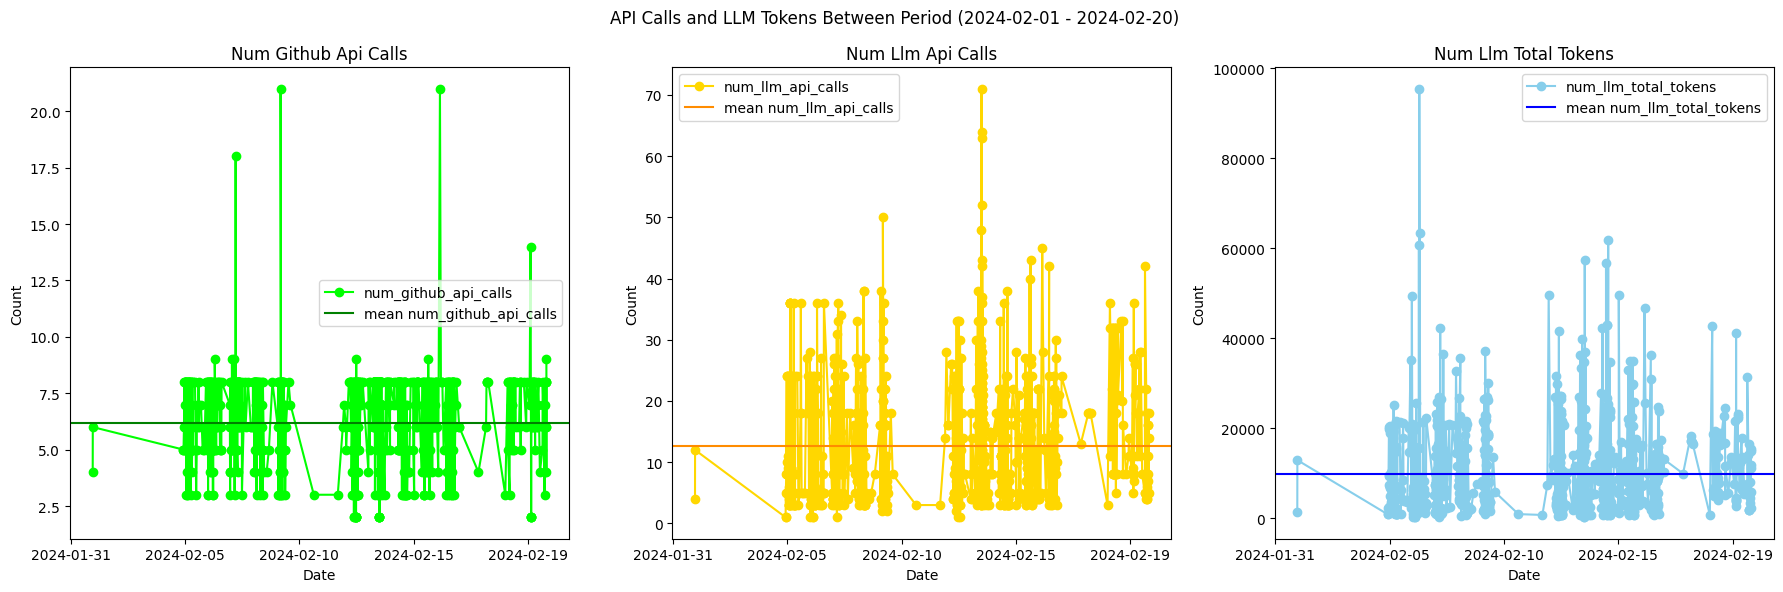

In [93]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle(f"API Calls and LLM Tokens Between Period ({start} - {end})")

graph_colors = {'num_github_api_calls': {'mean': 'green', 'default': 'lime'},
                'num_llm_api_calls': {'mean': 'darkorange', 'default': 'gold'},
                'num_llm_total_tokens': {'mean': 'blue', 'default': 'skyblue'}}

for col, col_name in enumerate(['num_github_api_calls', 'num_llm_api_calls', 'num_llm_total_tokens']):
    # axes[col].plot(avg_hourly_df.index, avg_hourly_df[col_name], label=f"mean {col_name}", marker='o', color=graph_colors[col_name]['mean'])
    # axes[col].plot(max_date_df.index, max_date_df[col_name], label=f"mean {col_name}", marker='o', color=graph_colors[col_name]['mean'])
    axes[col].plot(df['program_start_timestamp'], df[col_name], color=graph_colors[col_name]['default'], label=f"{col_name}", marker='o')
    axes[col].axhline(df[col_name].mean(), label=f"mean {col_name}", color=graph_colors[col_name]['mean'])
    axes[col].set_xticks(pd.date_range(start, end, periods=5))
    # axes[col].set_xticks(avg_hourly_df.index[::2])  # Display xticks every 2 hours
    axes[col].set_title(f"{col_name.replace('_', ' ').title()}")
    axes[col].set_xlabel("Date")
    axes[col].set_ylabel(f"Count")
    axes[col].legend()

plt.tight_layout()
plt.show()

In [10]:
# in above graph, make sure max is determined by sum per day, not PR
# expect to see ~2k values

In [11]:
# find busiest 10mins in 2 weeks, then divide by 10